# Imports and Data Wrangling

In [ ]:
! pip install -q kaggle

### Upload your kaggle key

Instructions to get your key:
**Authentication**
In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.

In [ ]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"goradiaa","key":"619af2c35e06edd2401903bf169baedf"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans


100% 1.03G/1.03G [00:12<00:00, 102MB/s] 



## Unzip the data

In [ ]:
! unzip covid19-ct-scans.zip

Archive:  covid19-ct-scans.zip
  inflating: ct_scans/coronacases_org_001.nii  
  inflating: ct_scans/coronacases_org_002.nii  
  inflating: ct_scans/coronacases_org_003.nii  
  inflating: ct_scans/coronacases_org_004.nii  
  inflating: ct_scans/coronacases_org_005.nii  
  inflating: ct_scans/coronacases_org_006.nii  
  inflating: ct_scans/coronacases_org_007.nii  
  inflating: ct_scans/coronacases_org_008.nii  
  inflating: ct_scans/coronacases_org_009.nii  
  inflating: ct_scans/coronacases_org_010.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.nii  
  inflating: ct_scans

In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
# Read and examine metadata
data = pd.read_csv('metadata.csv')
data['ct_scan'] = data['ct_scan'].str[26:]
data['lung_mask'] = data['lung_mask'].str[26:]
data['infection_mask'] = data['infection_mask'].str[26:]
data['lung_and_infection_mask'] = data['lung_and_infection_mask'].str[26:]

data.sample(2)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
3,ct_scans/coronacases_org_004.nii,lung_mask/coronacases_004.nii,infection_mask/coronacases_004.nii,lung_and_infection_mask/coronacases_004.nii
13,ct_scans/radiopaedia_org_covid-19-pneumonia-27...,lung_mask/radiopaedia_27_86410_0.nii,infection_mask/radiopaedia_27_86410_0.nii,lung_and_infection_mask/radiopaedia_27_86410_0...


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

# Sample Data

In [ ]:
# Read sample
sample_ct   = read_nii(data.loc[1,'ct_scan'])
sample_lung = read_nii(data.loc[1,'lung_mask'])
sample_infe = read_nii(data.loc[1,'infection_mask'])
sample_all  = read_nii(data.loc[1,'lung_and_infection_mask'])

Text(0.5, 1.0, 'Lung and Infection Mask')

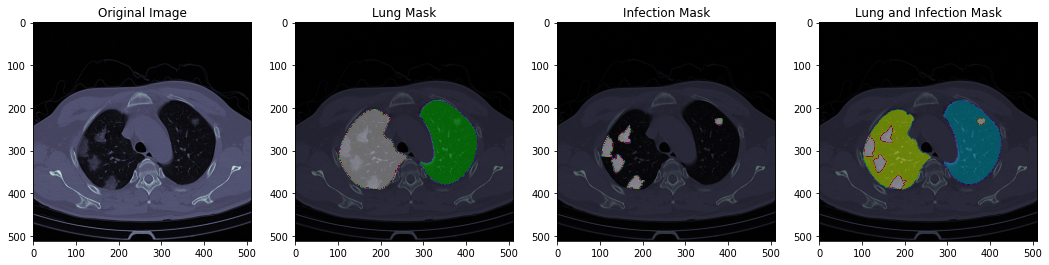

In [ ]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [ ]:
ct = read_nii(data['ct_scan'][0])
print(ct.shape)

(512, 512, 301)


In [ ]:
lungs = []
infections = []
groups = []
img_size = 256
import cv2
from tqdm import tqdm_notebook

total_count = 0
for i in tqdm_notebook(range(len(data))):
    ct = read_nii(data['ct_scan'][i])
    infect = read_nii(data['infection_mask'][i])
    
    init_count = total_count
    print(ct.shape)
    
    for ii in range(ct.shape[-1]):
        
        if ii==0:
            print(ct[..., ii].shape)
        
        lung_img = cv2.resize(ct[...,ii], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[...,ii],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        
#         lung_img = np.array(ct[...,ii])
#         infec_img = np.array(infect[...,ii])
        
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])
        groups.append(i)
        total_count += 1
    
    print(f"patient {i} ranges from {init_count} to {total_count-1}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


(512, 512, 301)
(512, 512)
patient 0 ranges from 0 to 300
(512, 512, 200)
(512, 512)
patient 1 ranges from 301 to 500
(512, 512, 200)
(512, 512)
patient 2 ranges from 501 to 700
(512, 512, 270)
(512, 512)
patient 3 ranges from 701 to 970
(512, 512, 290)
(512, 512)
patient 4 ranges from 971 to 1260
(512, 512, 213)
(512, 512)
patient 5 ranges from 1261 to 1473
(512, 512, 249)
(512, 512)
patient 6 ranges from 1474 to 1722
(512, 512, 301)
(512, 512)
patient 7 ranges from 1723 to 2023
(512, 512, 256)
(512, 512)
patient 8 ranges from 2024 to 2279
(512, 512, 301)
(512, 512)
patient 9 ranges from 2280 to 2580
(630, 630, 39)
(630, 630)
patient 10 ranges from 2581 to 2619
(630, 630, 418)
(630, 630)
patient 11 ranges from 2620 to 3037
(401, 630, 110)
(401, 630)
patient 12 ranges from 3038 to 3147
(630, 630, 66)
(630, 630)
patient 13 ranges from 3148 to 3213
(630, 630, 42)
(630, 630)
patient 14 ranges from 3214 to 3255
(630, 630, 42)
(630, 630)
patient 15 ranges from 3256 to 3297
(630, 630, 45)
(6

In [ ]:
lungs = np.array(lungs)
infections = np.array(infections)
groups = np.array(groups)

print(lungs.shape)
print(infections.shape)
print(groups.shape)

(3520, 256, 256, 1)
(3520, 256, 256, 1)
(3520,)


## Graph a sample image

169


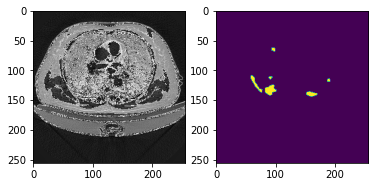

In [ ]:
import random
index = random.randint(0, len(lungs)-1)
print(index) # 10971 is a good one, 9564 is better
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(infections[index][:, :, 0])

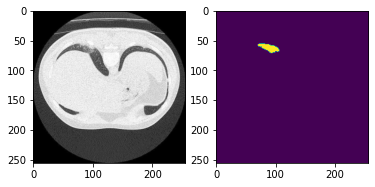

In [ ]:
index = 2700
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(infections[index][:, :, 0])

# Split Data

# New way to split data

In [ ]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(lungs, infections, groups)
from sklearn.utils import shuffle



train_index, test_index = group_kfold.split(lungs, infections, groups).__next__()
lung_train, lung_test = lungs[train_index], lungs[test_index]
infect_train, infect_test = infections[train_index], infections[test_index]

# # lets also shuffle the data
lung_train, infect_train = shuffle(lung_train, infect_train, random_state=0)
lung_test, infect_test = shuffle(lung_test, infect_test, random_state=0)

print(f"leaving out {np.unique(groups[test_index])}")
    # print(len(train_index))
    # print(len(test_index))


# for train_index, test_index in group_kfold.split(lungs, infections, groups):
#     print(f"leaving out {np.unique(groups[test_index])}")
#     # print(len(train_index))
#     # print(len(test_index))

#     lung_train, lung_test = lungs[train_index], lungs[test_index]
#     infect_train, infect_test = infections[train_index], infections[test_index]

#     # # lets also shuffle the data
#     lung_train, infect_train = shuffle(lung_train, infect_train, random_state=0)
#     lung_test, infect_test = shuffle(lung_test, infect_test, random_state=0)


leaving out [ 2 10 11 16]


### Just pick the last split to experiment on

# HR-Net


Losses:

In [ ]:
import numpy as np
from keras import backend as K
import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=0.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def loss(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return loss

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):


    #print("start")
    intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
    #print("mid")
    union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

    #print("ok")
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 10.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


Metrics:

In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def decimal_IOU(y_true, y_pred, smooth=0.001):
    #print("start")
    intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
    #print("mid")
    union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

    return K.mean( (intersection + smooth) / (union + smooth - intersection), axis=0)

In [ ]:
metrics=[tf.keras.metrics.MeanIoU(num_classes=2)]

Define Adam:

In [ ]:
custom_adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
)

Model:

In [ ]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import UpSampling2D, add, concatenate


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])
    return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(batch_size, height, width, channel, classes):
    inputs = Input(batch_shape=(batch_size,) + (height, width, channel))
    print(np.shape(inputs))

    x = stem_net(inputs)
    print(np.shape(x))


    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    x = transition_layer3(x)
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer3([x0, x1, x2, x3])

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model

Model summary:

In [ ]:
from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

hrnet_model = seg_hrnet(batch_size=None, height=256, width=256, channel=1, classes=1)
hrnet_model.summary()

#plot_model(model, to_file='seg_hrnet.png', show_shapes=True)

(None, 256, 256, 1)
(None, 128, 128, 256)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 576         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_____________________________________________

Choose loss for HR-net:

In [ ]:
#hrnet_model.compile(optimizer=custom_adam, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[dice_coef, 'binary_accuracy', decimal_IOU])
#hrnet_model.compile(optimizer=custom_adam, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[dice_coef, 'binary_accuracy', decimal_IOU])
#hrnet_model.compile(optimizer=custom_adam, loss=binary_focal_loss(alpha=0.8), metrics=[dice_coef, 'binary_accuracy', decimal_IOU]) 
hrnet_model.compile(optimizer=custom_adam, loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', decimal_IOU])


Train HR-net:

In [ ]:
hrnet_model.fit(lung_train, infect_train, epochs = 15, validation_data = (lung_test, infect_test), batch_size = 16)

Epoch 1/15
177/177 [==============================] - 81s 460ms/step - loss: 6.2729 - dice_coef: 0.0148 - binary_accuracy: 0.9481 - decimal_IOU: 0.0076 - val_loss: 11496.9229 - val_dice_coef: 0.0236 - val_binary_accuracy: 0.4250 - val_decimal_IOU: 0.0124
Epoch 2/15
177/177 [==============================] - 79s 449ms/step - loss: 5.3079 - dice_coef: 0.0167 - binary_accuracy: 0.9812 - decimal_IOU: 0.0087 - val_loss: 5.1540 - val_dice_coef: 0.0169 - val_binary_accuracy: 0.9448 - val_decimal_IOU: 0.0088
Epoch 3/15
177/177 [==============================] - 79s 448ms/step - loss: 4.8066 - dice_coef: 0.0144 - binary_accuracy: 0.9901 - decimal_IOU: 0.0074 - val_loss: 6.5811 - val_dice_coef: 0.0166 - val_binary_accuracy: 0.9870 - val_decimal_IOU: 0.0086
Epoch 4/15
177/177 [==============================] - 79s 448ms/step - loss: 4.3833 - dice_coef: 0.0155 - binary_accuracy: 0.9899 - decimal_IOU: 0.0080 - val_loss: 4.2255 - val_dice_coef: 0.0164 - val_binary_accuracy: 0.9840 - val_decimal_IOU:

# Visualize Test Results

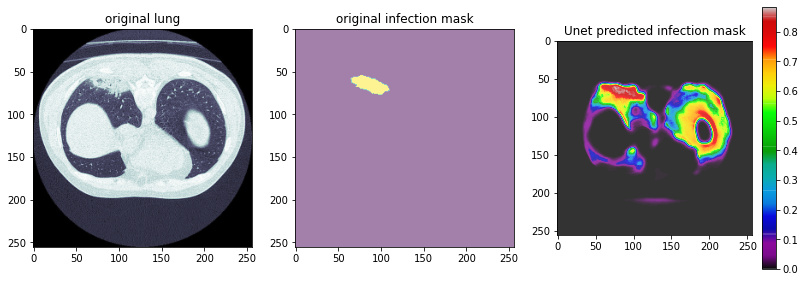

In [ ]:
import random
predicted_unet = unet_model.predict(lung_test)
predicted_hrnet = hrnet_model.predict(lung_test)
fig = plt.figure(figsize = (18,15))



# to force it to pick a covid examplem leave while loop uncommented
number = random.randint(0, len(lung_test))
while np.sum(infect_test[number][...,0])==0:
    number = random.randint(0, len(lung_test))

plt.subplot(1,4,1)
plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,4,2)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0],alpha = 0.5)
plt.title('original infection mask')

#plt.subplot(1,4,3)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
#plt.imshow(predicted_unet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
#plt.title('Unet predicted infection mask')

plt.subplot(1,4,4)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(predicted_hrnet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
plt.title('HRnet predicted infection mask')
plt.colorbar(fraction=0.06, pad=0.05)

# Confusion Matrix Code

In [ ]:
import sklearn
def get_confusion_matrix_elements(groundtruth_image, predicted_image, threshold):

    threshold_image = predicted_image>threshold


    groundtruth_list = groundtruth_image.ravel()
    predicted_list = threshold_image.ravel()


    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
    """
    all_sum = len(groundtruth_list)

    if np.sum(groundtruth_list)==all_sum and np.sum(predicted_list)==all_sum:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    elif np.sum(groundtruth_list)==0 and np.sum(predicted_list)==0:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0

    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp


def batch_confusion_matrix_elements(infection_masks, predicted_masks, threshold):
    results = []

    for i in tqdm_notebook(range(len(predicted_masks))):
        results.append(get_confusion_matrix_elements(infection_masks[i], predicted_masks[i], threshold))
    
    return np.sum(results, axis=0)


def report_classification_results(tn, fp, fn, tp):
    recall_covid = recall_value(tn, fp, fn, tp)
    precision_covid = precision_value(tn, fp, fn, tp)
    f1_score_covid = 1/(1/recall_covid + 1/precision_covid)

    recall_healthy = recall_value(tp, fn, fp, tn) # swap what the positive class is
    precision_healthy = precision_value(tp, fn, fp, tn)
    f1_score_healthy = 1/(1/recall_healthy + 1/precision_healthy)

    IOU_score = iou_value(tn, fp, fn, tp)
    dice_score = dice_value(tn, fp, fn, tp)


    print("Classification Report")
    print("--------------------------------")
    print(f"Covid Recall: {recall_covid*100}%")
    print(f"Covid Precision: {precision_covid*100}%")
    print(f"Covid F1: {f1_score_covid*100}%")
    print(f"Healthy Recall: {recall_healthy*100}%")
    print(f"Healthy Recall: {precision_healthy*100}%")
    print(f"Healthy F1: {f1_score_healthy*100}%")
    print("Segmentation metrics")
    print("---------------------------------")
    print(f"IOU value: {IOU_score}")
    print(f"Dice Score: {dice_score}")
    print("---------------------------------")



def confusion_matrix_plot_hacky(tn, fp, fn, tp):
    fake_label=np.zeros(int(tn))
    fake_predict = np.zeros(int(tn))

    fake_label = np.append(fake_label, np.zeros(int(fp)))
    fake_predict = np.append(fake_predict, np.ones(int(fp)))

    fake_label = np.append(fake_label, np.ones(int(fn)))
    fake_predict = np.append(fake_predict, np.zeros(int(fn)))

    fake_label = np.append(fake_label, np.ones(int(tp)))
    fake_predict = np.append(fake_predict, np.ones(int(tp)))

    print("Printing Classification Report")

    from sklearn.metrics import classification_report, confusion_matrix
    target_names = ['No Covid', 'Covid']
    report_classification_results(tn, fp, fn, tp)


    print("Printing Confusion Matrix")

    import seaborn as sns

    cm = confusion_matrix(fake_label, fake_predict)

    print(cm)
    ax= plt.subplot(1,1,1)
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['No Covid', 'Infected']); ax.yaxis.set_ticklabels(['No Covid', 'Infected']);


def iou_value(tn, fp, fn, tp):
    # IOU = true_positive / (true_positive + false_positive + false_negative)
    return tp / (tp + fp + fn)

def dice_value(tn, fp, fn, tp):
    # IOU = 2*true_positive / (2*true_positive + false_positive + false_negative)
    return 2*tp / (2*tp + fp + fn)

def precision_value(tn, fp, fn, tp):
    return tp / (tp + fp)

def recall_value(tn, fp, fn, tp):
    return tp / (tp + fn)


def plot_iou_chart(infection_masks, predicted_masks, thresholds):
    results = []
    precisions = []
    recalls = []
    for thresh in thresholds:
        tn, fp, fn, tp = batch_confusion_matrix_elements(infection_masks, predicted_masks, thresh)
        results.append(iou_value(tn, fp, fn, tp))
        precisions.append(precision_value(tn, fp, fn, tp))
        recalls.append(recall_value(tn, fp, fn, tp))
    
    plt.plot(thresholds, results)
    plt.xlabel("Threshold")
    plt.ylabel("IOU Value")
    plt.show()
    
    print("The results are as follows")
    print(f"IOU: {results}")
    print(f"Precision: {precisions}")
    print(f"Recall: {recalls}")
    print(f"Thresholds: {thresholds}")


(59615.0, 2236.0, 1586.0, 2099.0)
(61327.0, 524.0, 1449.0, 2236.0)


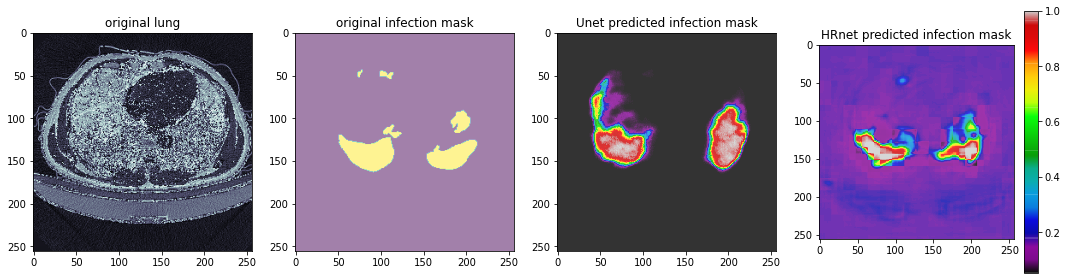

In [ ]:
predicted_unet = unet_model.predict(lung_test)
predicted_hrnet = hrnet_model.predict(lung_test)
fig = plt.figure(figsize = (18,12))


# force it to pick a covid example
number = random.randint(0, len(lung_test))
while np.sum(infect_test[number][...,0])==0:
    number = random.randint(0, len(lung_test))

plt.subplot(1,4,1)
plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,4,2)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0],alpha = 0.5)
plt.title('original infection mask')

#plt.subplot(1,4,3)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
#plt.imshow(predicted_unet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
#plt.title('Unet predicted infection mask')

plt.subplot(1,4,4)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(predicted_hrnet[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
plt.title('HRnet predicted infection mask')
plt.colorbar(fraction=0.06, pad=0.05)

print(get_confusion_matrix_elements(infect_test[number], predicted_unet[number], threshold = 0.5))
print(get_confusion_matrix_elements(infect_test[number], predicted_hrnet[number], threshold = 0.5))

## Make sure to change the Threshold value to see how it changes the results


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Printing Classification Report
Classification Report
--------------------------------
Covid Recall: 69.55718313235563%
Covid Precision: 40.478391025082104%
Covid F1: 25.587750861428315%
Healthy Recall: 99.10188641961058%
Healthy Recall: 99.73098847057508%
Healthy F1: 49.70772110690974%
Segmentation metrics
---------------------------------
IOU value: 0.3438647690083711
Dice Score: 0.5117550172285663
---------------------------------
Printing Confusion Matrix
[[45196221   409592]
 [  121911   278548]]


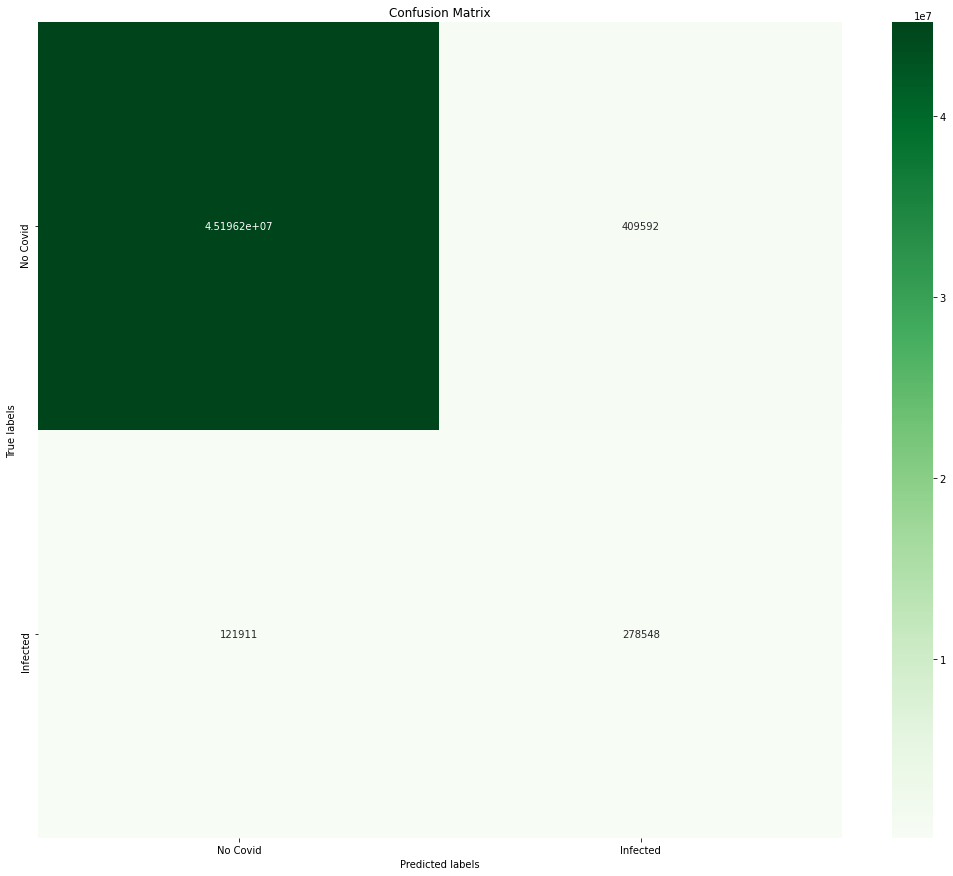

In [ ]:
#tn_u, fp_u, fn_u, tp_u = batch_confusion_matrix_elements(infect_test, predicted_unet, threshold=0.2)
tn_hr, fp_hr, fn_hr, tp_hr = batch_confusion_matrix_elements(infect_test, predicted_hrnet, threshold=0.2)

fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
confusion_matrix_plot_hacky(tn_hr, fp_hr, fn_hr, tp_hr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


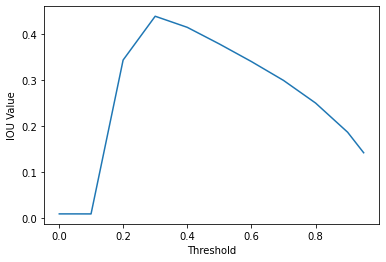

The results are as follows
IOU: [0.008704443602820067, 0.008704443602820067, 0.008704443602820067, 0.008704443602820067, 0.00870444814365214, 0.008704470091073946, 0.008640895080967367, 0.3438647690083711, 0.43927403667887444, 0.4151250016537527, 0.3788952742157418, 0.34056300567858766, 0.29952809641353273, 0.2502369528959685, 0.18662022318581184, 0.14192019455059804]
Precision: [0.008704443602820067, 0.008704443602820067, 0.008704443602820067, 0.008704443602820067, 0.00870444814365214, 0.008704470091073946, 0.008641464365192687, 0.40478391025082106, 0.6808113091579594, 0.7801466931874689, 0.8367893113240311, 0.8779991168244934, 0.9065347317844901, 0.9286519304878935, 0.9491173808086905, 0.9577806806002144]
Recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9924336823495039, 0.6955718313235563, 0.5532051970364007, 0.470123033818693, 0.40913052272517286, 0.3574797919387503, 0.30907283891734233, 0.25514222429761846, 0.18850618914795272, 0.14281362136947853]
Thresholds: [0.001, 0.01, 0.02, 0.03, 0.

In [ ]:
#plot_iou_chart(infect_test, predicted_unet, thresholds=[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
plot_iou_chart(infect_test, predicted_hrnet, thresholds=[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
